*   Outperforms Llama 2 13B on all benchmarks.
*   Outperforms Llama 1 34B on many benchmarks.
*   Approaches CodeLlama 7B performance on code, while remaining good at English tasks
*   **Uses Grouped-query attention** (GQA) for faster inference
*   **Uses Sliding Window Attention** (SWA) to handle longer sequences at smaller cost.

**Grouped Query Attention (GQA)**
Grouped Query Attention (GQA) is a technique introduced to optimize the balance between computational efficiency and model performance within Transformer architectures. Developed as an evolution of the Multi-Query Attention (MQA) technique, GQA addresses the inefficiencies inherent in the traditional attention mechanism using Multi-Head Attention (MHA), particularly concerning memory bandwidth demands during inference.

Multi-Query Attention is an earlier attempt to address these inefficiencies by employing a single key-value head across multiple query heads. While effective in speeding up inference, MQA can lead to quality degradation due to reduced capacity for capturing complex patterns, compared to MHA.

GQA adopts an intermediate approach between MHA and MQA, reducing the number of key-value heads without diminishing the model’s capacity to capture complex data relationships. This reduction is achieved by dividing the query heads into groups, each sharing a single key and value head.

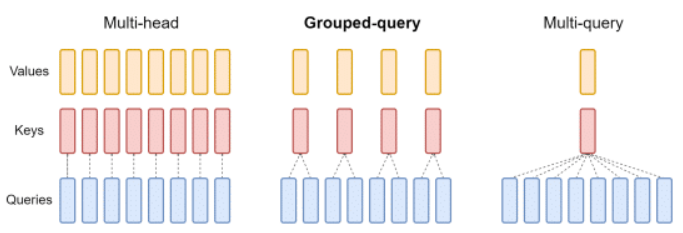


**Key Features of GQA:**

**Query Head Grouping:** GQA partitions query heads into groups, with each group sharing a single key and value head. This grouping significantly reduces the computational and memory overhead compared to traditional MHA, allowing for faster inference times without a substantial loss in model quality.


**Memory Bandwidth Optimization:** By minimizing the number of key-value pairs across groups, GQA mitigates the memory bandwidth challenge associated with key-value caching in MHA. This optimization ensures efficient loading and storing of data during inference, thereby enhancing overall computational efficiency.


**Balanced Trade-off:** GQA strikes a balance between the efficiency of MQA and the model expressiveness of MHA. It maintains a higher level of model capacity than MQA while offering speed benefits.


**Variable GQA** is an advanced version of **GQA**, where the number of key-value heads per attention layer is not fixed. This results in an even better balance between speed and accuracy than standard GQA. This technique is used in the DeciCoder-6B and DeciLM-7B models.

https://deci.ai/deep-learning-glossary/grouped-query-attention-gqa/#:~:text=Grouped%20Query%20Attention%20(GQA)%20is,model%20performance%20within%20Transformer%20architectures.

**Sliding Window Attention (SWA)**

https://klu.ai/glossary/sliding-window-attention

**What is Sliding Window Attention?**
Sliding Window Attention is like having a narrow spotlight in a dark room, where you can only focus on objects within a small area at a time. It's a smart way for LLMs to read and understand large texts without getting overwhelmed, by concentrating on a few words at a time.

Sliding Window Attention (SWA) is a technique used in transformer models to limit the attention span of each token to a fixed size window around it. This reduces the computational complexity and makes the model more efficient.

**How does Sliding Window Attention work?**
Sliding Window Attention (SWA) operates by partitioning the input sequence into overlapping segments, or "windows," each of a consistent size. Here's how it works:

The model first divides the input sequence into these windows, ensuring that each segment overlaps with the previous and next segments to maintain context continuity.

For each window, the model computes attention scores, which determine the relevance of each token within the window to the task at hand.

The attention mechanism then processes these windows sequentially, sliding across the input sequence and aggregating information from each window to inform the model's predictions.

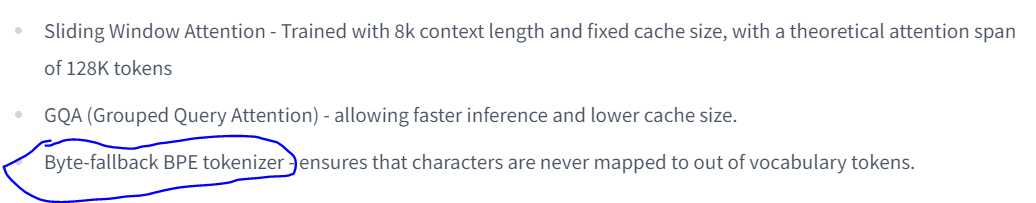

Byte-fallback BPE tokenizer: handles tokens that are not even part of vocabulary

## MISTRAL
https://huggingface.co/docs/transformers/en/model_doc/mistral

https://mistral.ai/news/announcing-mistral-7b/

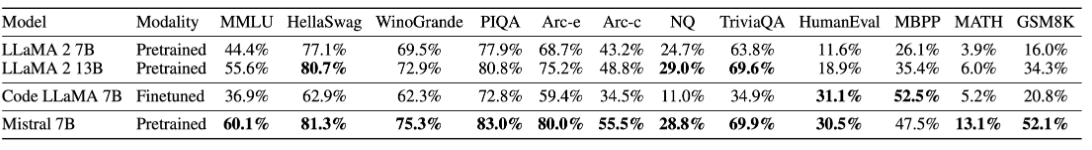

In [4]:
### USECASE: Summarize the dialoge

**accelerate:** are GPU related functions

**Peft:** is for LORA and QLORA

**bitsandBytes:** is for qunatization related

**TRL:** for using supervised fine tuning(SFT) trainer from transformers
reinforcement learning

**Autogptq:** is also quantization algorithms and it supports 8-bit and 4-bit quantization with bitsandbytes. GPTQ is just like bitsandbytes

**Optimum:** requirement for finetuning GPTQ models

**py7zr:** requirement for dataset

**prepare_model_for_kbit_training** just like loraconfig

dataset link https://huggingface.co/datasets/samsum

In [ ]:
! pip install accelerate peft bitsandbytes pip install git+https://github.com/huggingface/transformers trl py7zr auto-gptq optimum

In [2]:
from huggingface_hub import notebook_login
notebook_login()

## Quantisation link

https://huggingface.co/docs/transformers/main_classes/quantization#transformers.GPTQConfig

In [4]:
import torch
from datasets import load_dataset, Dataset
from peft import LoraConfig, AutoPeftModelForCausalLM, prepare_model_for_kbit_training, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig, TrainingArguments
from trl import SFTTrainer
import os

In [5]:
data = load_dataset("samsum", split="train")
data_df = data.to_pandas()
data_df["text"] = data_df[["dialogue", "summary"]].apply(lambda x: "###Human: Summarize this following dialogue: " + x["dialogue"] + "\n###Assistant: " +x["summary"], axis=1)
print(data_df.iloc[0])
data = Dataset.from_pandas(data_df)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

id                                                   13818513
dialogue    Amanda: I baked  cookies. Do you want some?\r\...
summary     Amanda baked cookies and will bring Jerry some...
text        ###Human: Summarize this following dialogue: A...
Name: 0, dtype: object


In [10]:
df = data.to_pandas().head(3)
df

,id,dialogue,summary,text
0,13818513,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...,###Human: Summarize this following dialogue: A...
1,13728867,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...,###Human: Summarize this following dialogue: O...
2,13681000,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...,###Human: Summarize this following dialogue: T...


# ***As usual we need everything(dialogue and summary) in single column or field for training purpose***

The key difference between **BitsAndBytesConfig** and **prepare_model_for_kbit_training** in LLM fine-tuning lies in their roles:

**BitsAndBytesConfig:**

**Function:** This class defines the configuration for how the model will be quantized. It acts as a blueprint for the quantization process.

**Purpose:** It allows you to specify various parameters related to quantization, such as:

    The target bit-width (e.g., 4 bits, 8 bits)
    Whether to load pre-quantized weights
    The type of quantization to use (e.g., post-training quantization, dynamic quantization)
    The data type for computations during training (e.g., bfloat16)
**Usage:** You create a **BitsAndBytesConfig** object, setting the desired quantization parameters, and then pass it to the **prepare_model_for_kbit_training** function.

**prepare_model_for_kbit_training:**

**Function:** This function is an action-oriented method that takes a pre-trained model and a BitsAndBytesConfig object and performs the actual quantization process.

**Purpose:** It utilizes the configuration provided by BitsAndBytesConfig to:

    Verify compatibility (optional)
    Perform calibration (if necessary)
    Convert weights and potentially activations to the lower-precision k-bit representation
    Make adjustments for the training framework to handle the quantized model

**Usage:** Once you have a pre-trained model and a configured BitsAndBytesConfig object, you call prepare_model_for_kbit_training with these as arguments to prepare the model for fine-tuning with the specified bit-width.

**Analogy:**

Think of BitsAndBytesConfig as a recipe (defining ingredients and steps) for making a k-bit quantized model. prepare_model_for_kbit_training is the chef who follows the recipe (the configuration) and uses the ingredients (the model) to actually cook (quantize) the model.

In [11]:
def finetune_mistral_7b():
    data = load_dataset("samsum", split="train")
    data_df = data.to_pandas()
    data_df["text"] = data_df[["dialogue", "summary"]].apply(lambda x: "###Human: Summarize this following dialogue: " + x["dialogue"] + "\n###Assistant: " +x["summary"], axis=1)
    print(data_df.iloc[0])
    data = Dataset.from_pandas(data_df)
    tokenizer = AutoTokenizer.from_pretrained("TheBloke/Mistral-7B-Instruct-v0.1-GPTQ") # model toeknizer, model has its own tokenizer so we will load it
    tokenizer.pad_token = tokenizer.eos_token # padding shorter sequences with a special token,  because neural networks typically expect fixed-size input tensors
    quantization_config_loading = GPTQConfig(bits=4, disable_exllama=True, tokenizer=tokenizer)   # gptq quantized model with 4 bits
    model = AutoModelForCausalLM.from_pretrained(
                              "TheBloke/Mistral-7B-Instruct-v0.1-GPTQ",
                              quantization_config=quantization_config_loading, # quantization config
                              device_map="auto" # will map device to layers, which is set to AUTO. this auto will try to map everything to single device(because single GPU)
                        ) # model checkpoint
    print(model)
    model.config.use_cache=False
    model.config.pretraining_tp=1
    model.gradient_checkpointing_enable()
    model = prepare_model_for_kbit_training(model) # we going to train the model for int 4(bits=4) so prepare_model_for_kbit_training will prepare the model int4 training

    peft_config = LoraConfig(
        r=16, lora_alpha=16, lora_dropout=0.05, bias="none", task_type="CAUSAL_LM", target_modules=["q_proj", "v_proj"]
    )
    model = get_peft_model(model, peft_config) # based
    training_arguments = TrainingArguments(
        output_dir="mistral-finetuned-samsum",
        per_device_train_batch_size=8,
        gradient_accumulation_steps=1,
        optim="paged_adamw_32bit",
        learning_rate=2e-4,
        lr_scheduler_type="cosine",
        save_strategy="epoch",
        logging_steps=100,
        num_train_epochs=1,
        max_steps=250,
        fp16=True,
        push_to_hub=True
    )
    trainer = SFTTrainer(
        model=model,
        train_dataset=data,
        peft_config=peft_config,
        dataset_text_field="text",
        args=training_arguments,
        tokenizer=tokenizer,
        packing=False,
        max_seq_length=512
    )
    trainer.train()
    trainer.push_to_hub()

if __name__ == "__main__":
    finetune_mistral_7b()

id                                                   13818513
dialogue    Amanda: I baked  cookies. Do you want some?\r\...
summary     Amanda baked cookies and will bring Jerry some...
text        ###Human: Summarize this following dialogue: A...
Name: 0, dtype: object


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Using `disable_exllama` is deprecated and will be removed in version 4.37. Use `use_exllama` instead and specify the version with `exllama_config`.The value of `use_exllama` will be overwritten by `disable_exllama` passed in `GPTQConfig` or stored in your config file.


config.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/quantizers/auto.py:155: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.However, loading attributes (e.g. ['use_cuda_fp16', 'use_exllama', 'max_input_length', 'exllama_config', 'disable_exllama']) will be overwritten with the one you passed to `from_pretrained`. The rest will be ignored.
  warnings.warn(warning_msg)


model.safetensors:   0%|          | 0.00/4.16G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:4195: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (rotary_emb): MistralRotaryEmbedding()
          (k_proj): QuantLinear()
          (o_proj): QuantLinear()
          (q_proj): QuantLinear()
          (v_proj): QuantLinear()
        )
        (mlp): MistralMLP(
          (act_fn): SiLU()
          (down_proj): QuantLinear()
          (gate_proj): QuantLinear()
          (up_proj): QuantLinear()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRMSNorm()
  )
  (lm_head): Linear(in_features=4096, out_features=32000, bias=False)
)


Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:294: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
100,1.872100
200,1.764100


adapter_model.safetensors:   0%|          | 0.00/27.3M [00:00<?, ?B/s]

events.out.tfevents.1709101679.bb0e2ae4fb56.760.0:   0%|          | 0.00/6.02k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

In [12]:
! cp -r /content/mistral-finetuned-samsum /content/drive/MyDrive/

##Inference
## the prompt template that we use here is alpaca prompt template

In [13]:
from peft import AutoPeftModelForCausalLM
from transformers import GenerationConfig
from transformers import AutoTokenizer
import torch
tokenizer = AutoTokenizer.from_pretrained("/content/mistral-finetuned-samsum")

## the prompt template that we use here is alpaca prompt template

inputs = tokenizer("""
###Human: Summarize this following dialogue: Vasanth: I'm at the railway station in Chennai Karthik: No problems so far? Vasanth: no, everything's going smoothly Karthik: good. lets meet there soon!
###Assistant: """, return_tensors="pt").to("cuda")

model = AutoPeftModelForCausalLM.from_pretrained(
    "/content/mistral-finetuned-samsum",
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="cuda")

generation_config = GenerationConfig(
    do_sample=True,
    top_k=1,
    temperature=0.1,
    max_new_tokens=25,
    pad_token_id=tokenizer.eos_token_id
)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:4195: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


In [14]:

import time
st_time = time.time()
outputs = model.generate(**inputs, generation_config=generation_config)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))
print(time.time()-st_time)


###Human: Summarize this following dialogue: Vasanth: I'm at the railway station in Chennai Karthik: No problems so far? Vasanth: no, everything's going smoothly Karthik: good. lets meet there soon!
###Assistant:  Vasanth is at the railway station in Chennai. Everything is going smoothly. He will meet Karthik soon.
29.640759706497192


In [17]:
outputs = model.generate(**inputs, generation_config=generation_config)

In [18]:
outputs

tensor([[    1, 28705,    13, 27332, 28769,  6366, 28747,  6927,  3479,   653,
           456,  2296, 19198, 28747, 19286, 12344, 28747,   315, 28742, 28719,
           438,   272, 18051,  5086,   297, 17038,  1520, 28710,   524,  3616,
           849, 28747,  1770,  4418,   579,  2082, 28804, 19286, 12344, 28747,
           708, 28725,  2905, 28742, 28713,  1404, 28147,   524,  3616,   849,
         28747,  1179, 28723, 16143,  2647,   736,  3403, 28808,    13, 27332,
          7226, 11143, 28747, 28705, 19286, 12344,   349,   438,   272, 18051,
          5086,   297, 17038,  1520, 28710, 28723, 13090,   349,  1404, 28147,
         28723,   650,   622,  2647,   524,  3616,   849,  3403, 28723]],
       device='cuda:0')

In [19]:
tokenizer.decode(outputs[0])

"<s> \n###Human: Summarize this following dialogue: Vasanth: I'm at the railway station in Chennai Karthik: No problems so far? Vasanth: no, everything's going smoothly Karthik: good. lets meet there soon!\n###Assistant:  Vasanth is at the railway station in Chennai. Everything is going smoothly. He will meet Karthik soon."